## Spectra generation

In [1]:
import multirex as mrex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys 
import pandas as pd
from tqdm import tqdm
import warnings
from sklearn.exceptions import DataConversionWarning
import gc

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def remove_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)    

waves=np.loadtxt("waves.txt")
n_points = len(waves)

Loading MultiREx version 0.2.3


## Load spectra

In [2]:
import os
import re
import numpy as np
import pandas as pd

def apply_contaminations_from_files(contamination_files, df, n_points):
    """
    Applies multiple contaminations to the data from a list of contamination files
    and returns a DataFrame with all combinations, including the non-contaminated case.

    Parameters:
        contamination_files (list of str): Paths to .txt files containing contaminations.
        df (pandas.DataFrame): Original DataFrame to apply contaminations.
        n_points (int): Number of columns to which the contamination will be applied.

    Returns:
        pandas.DataFrame: DataFrame with all combinations of contaminations, including the
        non-contaminated case, with additional columns 'f_spot' and 'f_fac'.
    """
    df_list = []

    # Non-contaminated case: create a copy and add f_spot and f_fac as 0.0
    df_no_contam = df.copy()
    df_no_contam["f_spot"] = 0.0
    df_no_contam["f_fac"] = 0.0
    # Reorder columns to place 'f_spot' and 'f_fac' at the beginning
    cols = ["f_spot", "f_fac"] + [col for col in df_no_contam.columns if col not in ["f_spot", "f_fac"]]
    df_no_contam = df_no_contam[cols]
    df_list.append(df_no_contam)

    # Regular expression to extract f_spot and f_fac from the file name.
    # Expected pattern: fspot<value>_ffac<value>.txt
    pattern = r"fspot(?P<f_spot>[0-9.]+)_ffac(?P<f_fac>[0-9.]+)\.txt$"

    for file_path in contamination_files:
        # Verify that the file exists
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist.")

        # Extract the file name and use the regex pattern to get f_spot and f_fac values
        filename = os.path.basename(file_path)
        match = re.search(pattern, filename)
        if not match:
            raise ValueError(f"The file name '{filename}' does not match the expected pattern.")

        f_spot = float(match.group("f_spot"))
        f_fac = float(match.group("f_fac"))

        # Read contamination data from the file, ensuring it has at least 2 dimensions
        try:
            contamination_data = np.loadtxt(file_path, ndmin=2)
            # If there are at least two columns, take the second one; otherwise, flatten the array
            if contamination_data.shape[1] >= 2:
                contam_values = contamination_data[:, 1]
            else:
                contam_values = contamination_data.flatten()
            # Check that the number of contamination values matches the expected n_points
            if len(contam_values) != n_points:
                raise ValueError(
                    f"The number of contamination values in '{filename}' ({len(contam_values)}) "
                    f"does not match n_points ({n_points})."
                )
        except Exception as e:
            raise ValueError(f"Error reading the file {file_path}: {e}")

        # Reverse the contamination values if needed (e.g., to match column order)
        contam_values = contam_values[::-1]

        # Create a copy of the original DataFrame for contamination application
        df_contam = df.copy()
        # Multiply the last n_points columns by the contamination values
        data_columns = df_contam.columns[-n_points:]
        df_contam[data_columns] = df_contam[data_columns].multiply(contam_values, axis=1)

        # Add the contamination parameters as new columns
        df_contam["f_spot"] = f_spot
        df_contam["f_fac"] = f_fac
        # Reorder columns to place the new parameters at the beginning
        cols = ["f_spot", "f_fac"] + [col for col in df_contam.columns if col not in ["f_spot", "f_fac"]]
        df_contam = df_contam[cols]
        df_list.append(df_contam)

    # Concatenate all DataFrames into one final DataFrame
    df_final = pd.concat(df_list, ignore_index=True)
    # Define .data and .params attributes for later use
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]

    return df_final

In [3]:
import pandas as pd

contamination_files = [
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.70.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.70.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.70.txt'
]


remove_warnings()

def filtrar_filas(df):
    """
    Filtra las filas de un DataFrame donde al menos una de las columnas
    "atm CH4", "atm O3" o "atm H2O" tenga un valor mayor o igual a -8.

    Si ninguna de estas columnas está presente, devuelve el DataFrame sin cambios.
    """
    columnas_a_filtrar = ["atm CH4", "atm O3", "atm H2O"]
    columnas_presentes = [col for col in columnas_a_filtrar if col in df.columns]

    for chem in columnas_presentes:

        df = df[df[chem]>=-8]
        df.data = df.iloc[:, -n_points:]
        df.params = df.iloc[:, :-n_points]

    return df
try:
    airless_data = pd.read_csv("spec_data/airless_data.csv")
    airless_data = apply_contaminations_from_files(contamination_files, airless_data, n_points)
except Exception as e:
    print(f"Error al procesar airless_data: {e}")

try:
    CO2_data = pd.read_csv("spec_data/CO2_data.csv")
    CO2_data = apply_contaminations_from_files(contamination_files, CO2_data, n_points)
except Exception as e:
    print(f"Error al procesar CO2_data: {e}")

try:
    CH4_data = pd.read_csv("spec_data/CH4_data.csv")
    CH4_data = filtrar_filas(CH4_data)
    CH4_data = apply_contaminations_from_files(contamination_files, CH4_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_data: {e}")

try:
    O3_data = pd.read_csv("spec_data/O3_data.csv")
    O3_data = filtrar_filas(O3_data)
    O3_data = apply_contaminations_from_files(contamination_files, O3_data, n_points)

except Exception as e:
    print(f"Error al procesar O3_data: {e}")

try:
    H2O_data = pd.read_csv("spec_data/H2O_data.csv")
    H2O_data = filtrar_filas(H2O_data)
    H2O_data = apply_contaminations_from_files(contamination_files, H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar H2O_data: {e}")

try:
    CH4_O3_data = pd.read_csv("spec_data/CH4_O3_data.csv")
    CH4_O3_data = filtrar_filas(CH4_O3_data)
    CH4_O3_data = apply_contaminations_from_files(contamination_files, CH4_O3_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_O3_data: {e}")

try:
    CH4_H2O_data = pd.read_csv("spec_data/CH4_H2O_data.csv")
    CH4_H2O_data = filtrar_filas(CH4_H2O_data)
    CH4_H2O_data = apply_contaminations_from_files(contamination_files, CH4_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_H2O_data: {e}")

try:
    O3_H2O_data = pd.read_csv("spec_data/O3_H2O_data.csv")
    O3_H2O_data = filtrar_filas(O3_H2O_data)
    O3_H2O_data = apply_contaminations_from_files(contamination_files, O3_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar O3_H2O_data: {e}")

try:
    CH4_O3_H2O_data = pd.read_csv("spec_data/CH4_O3_H2O_data.csv")
    CH4_O3_H2O_data = filtrar_filas(CH4_O3_H2O_data)
    CH4_O3_H2O_data = apply_contaminations_from_files(contamination_files, CH4_O3_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_O3_H2O_data: {e}")


C:\Users\User\AppData\Local\Temp\ipykernel_12100\20135952.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam["f_spot"] = f_spot
C:\Users\User\AppData\Local\Temp\ipykernel_12100\20135952.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam["f_fac"] = f_fac
C:\Users\User\AppData\Local\Temp\ipykernel_12100\20135952.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [4]:
CO2_data.iloc[:,-n_points:]

,5.297569,5.290111,5.28264,5.275158,5.267664,5.260158,5.252641,5.245111,5.237568,5.230015,...,0.764875,0.756764,0.748855,0.741148,0.733644,0.726317,0.71918,0.712225,0.705435,0.698805
0,0.005016,0.005017,0.005022,0.005028,0.005037,0.005037,0.005040,0.005038,0.005043,0.005044,...,0.005024,0.005025,0.005025,0.005026,0.005026,0.005027,0.005027,0.005027,0.005028,0.005028
1,0.005042,0.005039,0.005043,0.005054,0.005062,0.005058,0.005060,0.005058,0.005061,0.005060,...,0.005029,0.005030,0.005030,0.005031,0.005032,0.005032,0.005033,0.005033,0.005034,0.005035
2,0.005072,0.005068,0.005069,0.005087,0.005095,0.005083,0.005085,0.005091,0.005084,0.005083,...,0.005034,0.005035,0.005036,0.005037,0.005038,0.005039,0.005040,0.005040,0.005041,0.005042
3,0.004994,0.004964,0.004947,0.004992,0.004978,0.004996,0.004990,0.004957,0.004997,0.004986,...,0.004680,0.004805,0.004729,0.004778,0.004927,0.004872,0.004849,0.004817,0.004888,0.004876
4,0.005019,0.004985,0.004968,0.005017,0.005003,0.005018,0.005010,0.004977,0.005015,0.005002,...,0.004685,0.004810,0.004734,0.004783,0.004933,0.004878,0.004855,0.004823,0.004894,0.004882
5,0.005049,0.005015,0.004993,0.005050,0.005036,0.005042,0.005035,0.005009,0.005037,0.005024,...,0.004690,0.004816,0.004739,0.004789,0.004939,0.004884,0.004862,0.004830,0.004901,0.004889
6,0.004799,0.004610,0.004497,0.004720,0.004602,0.004705,0.004655,0.004480,0.004677,0.004612,...,0.003252,0.003698,0.003408,0.003587,0.004250,0.004003,0.003916,0.003784,0.004061,0.004006
7,0.004823,0.004630,0.004515,0.004743,0.004625,0.004725,0.004674,0.004498,0.004694,0.004627,...,0.003255,0.003701,0.003412,0.003591,0.004254,0.004008,0.003921,0.003788,0.004066,0.004011
8,0.004852,0.004658,0.004539,0.004775,0.004656,0.004748,0.004697,0.004527,0.004715,0.004647,...,0.003258,0.003705,0.003415,0.003595,0.004260,0.004013,0.003926,0.003794,0.004071,0.004017
9,0.004734,0.004499,0.004359,0.004632,0.004484,0.004611,0.004549,0.004334,0.004576,0.004494,...,0.002940,0.003423,0.003106,0.003301,0.004056,0.003769,0.003671,0.003521,0.003835,0.003772


In [5]:
# Función para normalizar por filas con Min-Max, con manejo de casos especiales
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    range_by_row = max_by_row - min_by_row
    # Evitar división por cero asignando NaN, que luego reemplazaremos
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    # Manejar filas donde max == min (rango es cero), puedes ajustar este valor
    normalized[range_by_row == 0] = 0  # O cualquier otro valor que consideres apropiado
    return normalized

import ast
# Función para convertir string a lista
def string_to_list(string):
    return ast.literal_eval(string)

def plot_confusion_matrix(y_test, y_pred, labels, display_labels, title):
    """
    Función para calcular y mostrar la matriz de confusión con etiquetas descriptivas y un título personalizado.

    Parámetros:
    - y_test: Array con los valores reales.
    - y_pred: Array con las predicciones del modelo.
    - labels: Lista de las etiquetas de clase en el orden en que deben ser tratadas.
    - display_labels: Lista con los nombres descriptivos para las etiquetas de las clases para visualización.
    - title: String con el título para el gráfico de la matriz de confusión.
    """

    # Calcula la matriz de confusión con las etiquetas descriptivas
    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

    # Crea el display de la matriz de confusión con etiquetas descriptivas
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=display_labels)
    disp.plot(values_format=".0%", colorbar=True, ax=ax)
    disp.im_.colorbar.remove()
    disp.im_.set_clim(0, 1)

    # Crea manualmente la barra de colores con los límites correctos
    cbar = fig.colorbar(disp.im_, ax=ax)
    cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))  # Corrige el formateador para mostrar en porcentajes

    plt.subplots_adjust(left=0.1, right=0.9, 
                        top=0.9, bottom=0.1)
    plt.title(title, fontsize=20)

    plt.show()
    

mix_ratios = np.logspace(-8,-1,8)


In [6]:
import numpy as np
import pandas as pd
import warnings

def generate_df_with_noise_std(df, n_repeat, noise_std, seed=None):
    """
    Genera un nuevo DataFrame aplicando ruido Gaussiano de desviación estándar especificada
    a los espectros de manera vectorizada y concatena el resultado con otro DataFrame que
    contiene otras columnas de información.

    Parámetros:
    - df: DataFrame con parámetros y espectros. Debe tener atributos 'params' y 'data'.
          Ejemplo: df.params, df.data
    - n_repeat: Número de veces que se replica cada espectro.
    - noise_std: Desviación estándar del ruido a aplicar. Puede ser un número único o una
                 lista/array con una desviación estándar para cada espectro.
    - seed: Semilla para el generador de números aleatorios (opcional).

    Retorna:
    - Nuevo DataFrame con parámetros y espectros con ruido agregado en el mismo formato
      que el DataFrame de entrada. df.params, df.data
    """
    # Verificación de atributos 'params' y 'data' en el DataFrame
    if not hasattr(df, "params"):
        print("Advertencia: No se encontró el atributo 'params' en el DataFrame.")
        df_params = pd.DataFrame()
        if not hasattr(df, "data"):
            print("Advertencia: No se encontró el atributo 'data' en el DataFrame.",
                  "Se considerará que el DataFrame contiene solo datos espectrales.")
            df_spectra = df
    else:
        if not hasattr(df, "data"):
            raise ValueError("El DataFrame debe tener un atributo 'data'.")
        else:
            df_params = df.params
            df_spectra = df.data

    # Validaciones de tipos y valores de los parámetros
    if not isinstance(df_spectra, pd.DataFrame):
        raise ValueError("df_spectra debe ser un pandas DataFrame.")
    if not isinstance(df_params, pd.DataFrame):
        raise ValueError("df_params debe ser un pandas DataFrame.")
    if (not isinstance(n_repeat, int) or n_repeat <= 0):
        raise ValueError("n_repeat debe ser un entero positivo.")
    if isinstance(noise_std, (int, float)):
        if noise_std < 0:
            raise ValueError("noise_std debe ser un número positivo.")
    elif isinstance(noise_std, (list, np.ndarray, pd.Series)):
        if not all(n > 0 for n in noise_std):
            raise ValueError("Todos los valores en noise_std deben ser positivos.")
        if len(noise_std) != len(df_spectra):
            raise ValueError("La longitud de noise_std debe coincidir con el número de espectros en df.")
    else:
        raise ValueError("noise_std debe ser un número positivo o una lista/array de números positivos.")
    if (seed is not None and
        (not isinstance(seed, int) or seed < 0)):
        raise ValueError("seed debe ser un entero no negativo.")

    # Configuración de la semilla para reproducibilidad
    if seed is not None:
        np.random.seed(seed)  

    # Replicación del DataFrame de espectros según el factor de repetición
    df_spectra_replicated = pd.DataFrame(
        np.repeat(df_spectra.values, n_repeat, axis=0),
        columns=df_spectra.columns
    )

    # Manejo de noise_std: si es escalar, se expande; si es array, se replica según n_repeat
    if isinstance(noise_std, (int, float)):
        noise_replicated = np.full(df_spectra_replicated.shape, noise_std)
    else:
        noise_array = np.array(noise_std)
        noise_replicated = np.repeat(noise_array[:, np.newaxis], n_repeat, axis=0)
        noise_replicated = np.tile(noise_replicated, (1, df_spectra_replicated.shape[1]))

    # Aplicación vectorizada del ruido Gaussiano
    gaussian_noise = np.random.normal(0, noise_replicated, df_spectra_replicated.shape)
    df_spectra_replicated += gaussian_noise

    # Replicación del DataFrame de parámetros para que coincida con el número de filas de los espectros replicados
    df_other_columns_replicated = pd.DataFrame(
        np.repeat(df_params.values, n_repeat, axis=0),
        columns=df_params.columns
    )

    # Inserción de la columna 'noise' y 'noise_std' en los parámetros replicados
    if isinstance(noise_std, (int, float)):
        df_other_columns_replicated.insert(0, 'noise_std', noise_std)
    else:
        df_other_columns_replicated.insert(0, 'noise_std', np.repeat(noise_std, n_repeat))
    df_other_columns_replicated.insert(1, 'n_repeat', n_repeat)

    # Concatenación de parámetros y espectros ruidosos
    df_final = pd.concat(
        [df_other_columns_replicated.reset_index(drop=True),
         df_spectra_replicated.reset_index(drop=True)],
        axis=1
    )

    # Asignación de atributos 'data' y 'params' al DataFrame final
    warnings.filterwarnings("ignore")
    df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1]:]
    df_final.params = df_final.iloc[:, :df_other_columns_replicated.shape[1]]
    warnings.filterwarnings("default")
    
    return df_final


## SNR =1



In [17]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=1     
)["noise"][1]

SNR1_CO2 = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise
    )

SNR1_CH4 = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=1000,
    noise_std = noise 
    )

SNR1_airless = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR1_CO2_CH4=pd.concat(
    [
    SNR1_CO2,
    SNR1_CH4,  
    SNR1_airless,
    ],
    ignore_index=True)

SNR1_CO2_CH4["label"] = SNR1_CO2_CH4["label"].apply(string_to_list)
SNR1_CO2_CH4["label"] = SNR1_CO2_CH4["label"].apply(lambda x: x[0])

del (
    SNR1_CO2,
    SNR1_CH4,  
    SNR1_airless
)

gc.collect()

print(SNR1_CO2_CH4["label"].value_counts())



label
0    400000
1    240000
Name: count, dtype: int64


## SNR =3



In [21]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR = 3     
)["noise"][1]

SNR3_CO2 = generate_df_with_noise_std(
    df = CO2_data,
    n_repeat = 7_000,
    noise_std = noise
    )

SNR3_CH4 = generate_df_with_noise_std(
    df = CH4_data,
    n_repeat = 1_000,
    noise_std = noise 
    )

SNR3_airless = generate_df_with_noise_std(
    df = airless_data,
    n_repeat = 7_000,
    noise_std = noise   
)

SNR3_CO2_CH4=pd.concat(
    [
    SNR3_CO2,
    SNR3_CH4,  
    SNR3_airless,
    ],
    ignore_index=True)

SNR3_CO2_CH4["label"] = SNR3_CO2_CH4["label"].apply(string_to_list)
SNR3_CO2_CH4["label"] = SNR3_CO2_CH4["label"].apply(lambda x: x[0])

del (
    SNR3_CO2,
    SNR3_CH4,  
    SNR3_airless
)

gc.collect()

print(SNR3_CO2_CH4["label"].value_counts())




label
0    280000
1    240000
Name: count, dtype: int64


## SNR= 6



In [22]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR = 6     
)["noise"][1]

SNR6_CO2 = generate_df_with_noise_std(
    df = CO2_data,
    n_repeat = 5_000,
    noise_std = noise
    )

SNR6_CH4 = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=500,
    noise_std = noise
    )

SNR6_airless = generate_df_with_noise_std(
    df = airless_data,
    n_repeat = 5_000,
    noise_std = noise   
)

SNR6_CO2_CH4=pd.concat(
    [
    SNR6_CO2,
    SNR6_CH4,  
    SNR6_airless,
    ],
    ignore_index=True)

SNR6_CO2_CH4["label"] = SNR6_CO2_CH4["label"].apply(string_to_list)
SNR6_CO2_CH4["label"] = SNR6_CO2_CH4["label"].apply(lambda x: x[0])

del (
    SNR6_CO2,
    SNR6_CH4,  
    SNR6_airless
)

gc.collect()

print(SNR6_CO2_CH4["label"].value_counts())


label
0    200000
1    120000
Name: count, dtype: int64


## SNR=10

In [23]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR = 10     
)["noise"][1]


SNR10_CO2 = generate_df_with_noise_std(
    df = CO2_data,
    n_repeat = 5_000,
    noise_std = noise
    )
SNR10_CH4 = generate_df_with_noise_std(
    df = CH4_data,
    n_repeat = 500,
    noise_std = noise 
    )

SNR10_airless = generate_df_with_noise_std(
    df = airless_data,
    n_repeat = 5_000,
    noise_std = noise   
)

SNR10_CO2_CH4=pd.concat(
    [
    SNR10_CO2,
    SNR10_CH4,  
    SNR10_airless,
    ],
    ignore_index=True)

SNR10_CO2_CH4["label"] = SNR10_CO2_CH4["label"].apply(string_to_list)
SNR10_CO2_CH4["label"] = SNR10_CO2_CH4["label"].apply(lambda x: x[0])

del (
    SNR10_CO2,
    SNR10_CH4,  
    SNR10_airless
)

gc.collect()

print(SNR10_CO2_CH4["label"].value_counts())

label
0    200000
1    120000
Name: count, dtype: int64


## No Noise

In [24]:
SNRnan_CO2 = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = 0)

SNRnan_CH4 = generate_df_with_noise_std(
    df = CH4_data,
    n_repeat = 2000,
    noise_std = 0)

SNRnan_airless = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = 0   
)

SNRnan_CO2_CH4=pd.concat(
    [
    SNRnan_CO2,
    SNRnan_CH4,  
    SNRnan_airless,
    ],
    ignore_index=True)

SNRnan_CO2_CH4["label"] = SNRnan_CO2_CH4["label"].apply(string_to_list)
SNRnan_CO2_CH4["label"] = SNRnan_CO2_CH4["label"].apply(lambda x: x[0])

del (
    SNRnan_CO2,
    SNRnan_CH4,  
    SNRnan_airless
)

gc.collect()

print(SNRnan_CO2_CH4["label"].value_counts())

label
1    480000
0    400000
Name: count, dtype: int64


## ALL SNR

In [25]:
SNRall = pd.concat([SNR1_CO2_CH4,SNR3_CO2_CH4,SNR6_CO2_CH4,SNR10_CO2_CH4,SNRnan_CO2_CH4],ignore_index=True)

SNRall["label"].value_counts()

label
0    1480000
1    1200000
Name: count, dtype: int64

In [26]:
SNRall_train, SNRall_test = train_test_split(SNRall, test_size=0.2,)

del SNRall

gc.collect

SNRall_train.iloc[:,-n_points:]=normalize_min_max_by_row(SNRall_train.iloc[:,-n_points:])
SNRall_test.iloc[:,-n_points:]=normalize_min_max_by_row(SNRall_test.iloc[:,-n_points:])
SNRall_X_train = SNRall_train.iloc[:, -n_points:]
SNRall_y_train = SNRall_train["label"].astype(int)
SNRall_X_test = SNRall_test.iloc[:, -n_points:]
SNRall_y_test = SNRall_test["label"].astype(int)


### rf

In [27]:
from tensorflow import keras 

encoder = keras.models.load_model("AE_CH4.keras") # for specialized AE
#encoder = keras.models.load_model("AE.keras") # for common AE

SNRall_X_train = encoder.predict(SNRall_X_train)

SNRall_X_test = encoder.predict(SNRall_X_test)

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


67000/67000 ━━━━━━━━━━━━━━━━━━━━ 382s 6ms/step
16750/16750 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step


In [ ]:
SNRall_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=200,
    criterion="entropy",
    min_samples_leaf=3,
    n_jobs=-1
                            )

SNRall_rf.fit(SNRall_X_train, SNRall_y_train) 

import joblib
joblib.dump(SNRall_rf, "CH4_rf_S.joblib") # Specialized Autoencoder
joblib.dump(SNRall_rf, "CH4_rf_C.joblib") # Common Autoencoder

['CH4_rf_S.joblib']

In [ ]:
""" from tensorflow import keras 

encoder = keras.models.load_model("AE_CH4.keras") # for specialized AE
import joblib
SNRall_rf = joblib.load("CH4_rf_S.joblib") """

[[283132  12450]
 [ 41912 198506]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91    295582
           1       0.94      0.83      0.88    240418

    accuracy                           0.90    536000
   macro avg       0.91      0.89      0.90    536000
weighted avg       0.90      0.90      0.90    536000



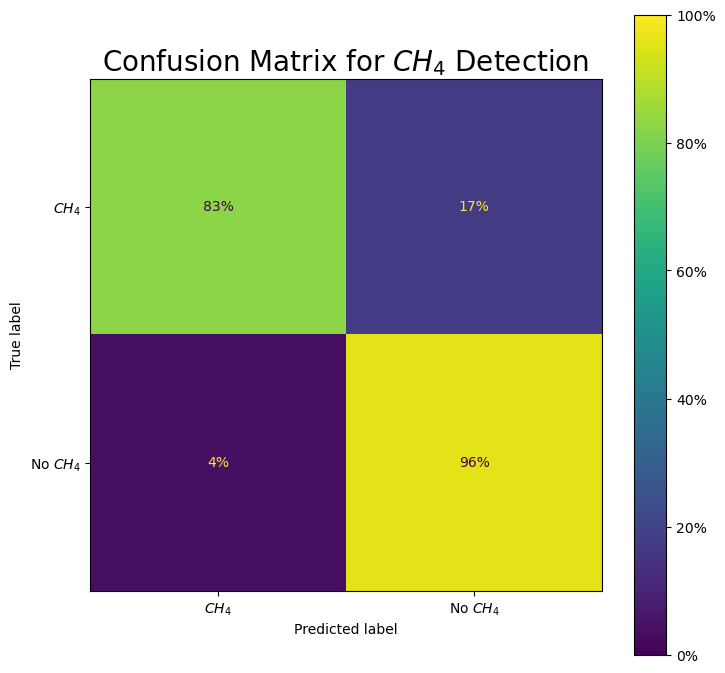

In [29]:
SNRall_probabilities = SNRall_rf.predict_proba(SNRall_X_test)[:, 1]

# Asignar etiquetas basadas en el umbral ajustado
threshold = 0.5
remove_warnings()
SNRall_y_pred = (SNRall_probabilities > threshold).astype(int)

# Asignar etiquetas y puntuaciones a las predicciones
SNRall_test["pred"] = SNRall_y_pred
SNRall_test["score"] = SNRall_probabilities

# Imprimir la matriz de confusión y el informe de clasificación
print(confusion_matrix(SNRall_y_test, SNRall_y_pred))
print(classification_report(SNRall_y_test, SNRall_y_pred))

plot_confusion_matrix(
    SNRall_y_test, SNRall_y_pred,
    labels=[1,0], display_labels=["$CH_4$", "No $CH_4$"],
    title="Confusion Matrix for $CH_4$ Detection "
)



### Validation

In [8]:
SNR = 1

SNR_val_CO2 = mrex.generate_df_SNR_noise(df=CO2_data,
                                        n_repeat=10000,
                                        SNR=SNR)
SNR_val_CH4 = mrex.generate_df_SNR_noise(df=CH4_data,
                                         n_repeat=1000,
                                         SNR=SNR)
SNR_val= pd.concat(
    [
        SNR_val_CO2,
        SNR_val_CH4
        ],
        ignore_index=True)


del (
    SNR_val_CO2,
    SNR_val_CH4
)

gc.collect()

SNR_val["label"] = SNR_val["label"].apply(string_to_list)
SNR_val["label"] = SNR_val["label"].apply(lambda x: x[0])

SNR_val_test = SNR_val


SNR_val_test.iloc[:,-n_points:]=normalize_min_max_by_row(SNR_val_test.iloc[:,-n_points:])


SNR_val_X_test = SNR_val_test.iloc[:, -n_points:]
SNR_val_y_test = SNR_val_test["label"].astype(int)

In [9]:
SNR_val_X_test

,5.297569,5.290111,5.28264,5.275158,5.267664,5.260158,5.252641,5.245111,5.237568,5.230015,...,0.764875,0.756764,0.748855,0.741148,0.733644,0.726317,0.71918,0.712225,0.705435,0.698805
0,0.617411,0.396994,0.226161,0.677659,0.163082,0.285202,0.736309,0.394004,0.463993,0.690759,...,0.770312,0.304342,0.341343,0.210905,0.370264,0.679028,0.451090,0.452520,0.267141,0.511184
1,0.374335,0.701426,0.585355,0.585388,0.625147,0.646304,0.419283,0.624429,0.580649,0.726157,...,0.519550,0.533754,0.550366,0.555265,0.624098,0.475803,0.472663,0.529361,0.247299,0.752970
2,0.346149,0.606807,0.438921,0.407952,0.464600,0.464517,0.648641,0.548392,0.833332,0.738617,...,0.254288,0.725194,0.383655,0.579061,0.432052,0.537086,0.463980,0.459178,0.306166,0.256830
3,0.788331,0.721404,0.551699,0.213025,0.523799,0.553072,0.157439,0.282569,0.319656,0.609712,...,0.557059,0.510582,0.339766,0.368390,0.498758,0.660154,0.278474,0.493421,0.671023,0.635055
4,0.512679,0.450947,0.155993,0.343358,0.631585,0.592360,0.663595,0.784618,0.734044,0.806768,...,0.695797,0.375876,0.301546,0.473887,0.558435,0.475478,0.563365,0.380715,0.456121,0.757998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539995,0.669798,0.637534,0.577172,0.456232,0.672227,0.528550,0.348966,0.422876,0.286913,0.466121,...,0.459394,0.315398,0.455389,0.443688,0.620666,0.446402,0.476110,0.609276,0.626542,0.547519
539996,0.127936,0.386177,0.620967,0.713778,0.202239,0.590816,0.220946,0.465755,0.621975,0.252957,...,0.455628,0.292399,0.045180,0.346811,0.423622,0.360085,0.393520,0.538736,0.478220,0.598188
539997,0.481319,0.520013,0.844592,0.623096,0.549240,0.576764,0.349441,0.567756,0.432767,0.424855,...,0.079691,0.478034,0.529659,0.718853,0.242278,0.401302,0.444922,0.713476,0.254405,0.546902
539998,0.746011,0.688182,0.233178,0.476661,0.372888,0.764010,0.664219,0.539421,0.251479,0.731130,...,0.293517,0.573683,0.168307,0.295518,0.419917,0.449809,0.402622,0.437943,0.423001,0.358098


[[201339  98661]
 [149213  90787]]
              precision    recall  f1-score   support

           0       0.57      0.67      0.62    300000
           1       0.48      0.38      0.42    240000

    accuracy                           0.54    540000
   macro avg       0.53      0.52      0.52    540000
weighted avg       0.53      0.54      0.53    540000



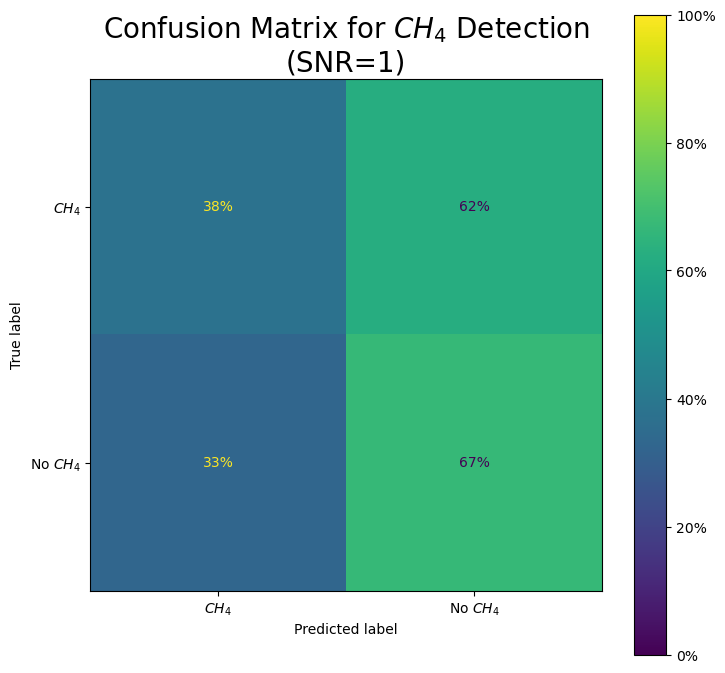

In [13]:
remove_warnings()
#SNR_val_X_test = encoder.predict(SNR_val_X_test)
SNR_val_predictions = SNRall_rf.predict_proba(SNR_val_X_test)[:, 1]
threshold = 0.2
SNR_val_y_pred = (SNR_val_predictions > threshold).astype(int)
SNR_val_test["pred"] = SNR_val_y_pred
SNR_val_test["score"] = SNR_val_predictions


print(confusion_matrix(SNR_val_y_test, SNR_val_y_pred))
print(classification_report(SNR_val_y_test, SNR_val_y_pred))

plot_confusion_matrix(
    SNR_val_y_test, SNR_val_y_pred,
    labels=[1,0], display_labels=["$CH_4$", "No $CH_4$"],
    title=f"Confusion Matrix for $CH_4$ Detection\n(SNR={SNR})"
)

label
0    37500
1    30000
Name: count, dtype: int64
label
0    37500
1    30000
Name: count, dtype: int64
label
0    37500
1    30000
Name: count, dtype: int64
label
0    37500
1    30000
Name: count, dtype: int64
label
0    37500
1    30000
Name: count, dtype: int64
label
0    37500
1    30000
Name: count, dtype: int64
label
0    37500
1    30000
Name: count, dtype: int64
label
0    37500
1    30000
Name: count, dtype: int64
mix ratio:CH4=1e-08
[[25238 12262]
 [20059  9941]]
mean score of :CH4=1e-08 is 0.16411171392893395
mix ratio:CH4=1e-07
[[25250 12250]
 [19895 10105]]
mean score of :CH4=1e-07 is 0.16709250979512327
mix ratio:CH4=1e-06
[[25177 12323]
 [19350 10650]]
mean score of :CH4=1e-06 is 0.17886022101306998
mix ratio:CH4=1e-05
[[25204 12296]
 [18767 11233]]
mean score of :CH4=1e-05 is 0.2029541825010137
mix ratio:CH4=0.0001
[[25238 12262]
 [18102 11898]]
mean score of :CH4=0.0001 is 0.24043000625309593
mix ratio:CH4=0.001
[[25216 12284]
 [17689 12311]]
mean score of :CH4=0.

Text(0.5, 1.0, 'Scores for $CH_4$ Detection\n(SNR=1)')

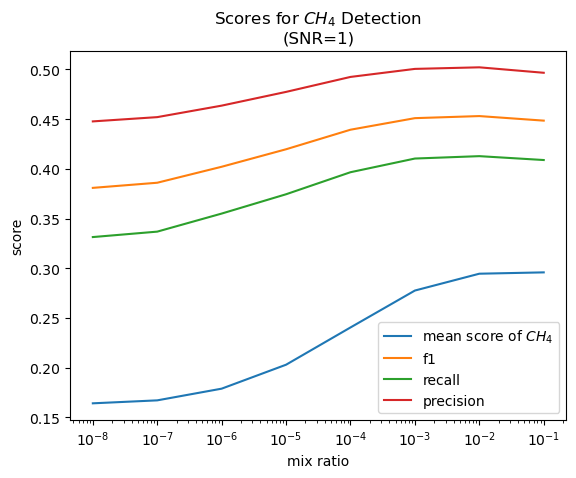

In [14]:
SNR_val_by_atmCH4=[[] for i in range(8)]

for i, j in enumerate(range(-8,-0)):
    SNR_val_by_atmCH4[i]=SNR_val_test[SNR_val_test["atm CH4"]==j]
    co2=int(len(SNR_val_test[SNR_val_test["label"]==0])/8)
    SNR_val_by_atmCH4[i]=pd.concat([SNR_val_by_atmCH4[i],
                                      SNR_val_test[SNR_val_test["label"]==0].sample(n=co2)])
    print(SNR_val_by_atmCH4[i]["label"].value_counts())
    
SNR_val_f1 = np.zeros(len(mix_ratios))
SNR_val_recall = np.zeros(len(mix_ratios))
SNR_val_precision = np.zeros(len(mix_ratios))
SNR_val_score = np.zeros(len(mix_ratios))

for j in range(len(mix_ratios)):
                
                SNR_val_f1[j] = f1_score(
                    SNR_val_by_atmCH4[j]["label"].astype(int),
                    SNR_val_by_atmCH4[j]["pred"].astype(int)
                    )
                
                SNR_val_recall[j] = recall_score(
                    SNR_val_by_atmCH4[j]["label"].astype(int),
                    SNR_val_by_atmCH4[j]["pred"].astype(int)
                    )
                
                SNR_val_precision[j]=precision_score(
                    SNR_val_by_atmCH4[j]["label"].astype(int),
                    SNR_val_by_atmCH4[j]["pred"].astype(int)
                    )
                
                print(f"mix ratio:CH4={mix_ratios[j]}")
                print(confusion_matrix(SNR_val_by_atmCH4[j]["label"].astype(int),
                                    SNR_val_by_atmCH4[j]["pred"].astype(int)))
                
                ## mean of probabilities of label 1
                print(f"mean score of :CH4={mix_ratios[j ]} is {SNR_val_by_atmCH4[j][SNR_val_by_atmCH4[j]['label']==1]['score'].mean()}")
                SNR_val_score[j] = SNR_val_by_atmCH4[j][
                    SNR_val_by_atmCH4[j]['label']==1
                    ]['score'].mean()

## plot scores
plt.figure()
plt.plot(mix_ratios,SNR_val_score,label="mean score of $CH_4$")
plt.plot(mix_ratios,SNR_val_f1,label="f1")
plt.plot(mix_ratios,SNR_val_recall,label="recall")
plt.plot(mix_ratios,SNR_val_precision,label="precision")

plt.xlabel("mix ratio")
plt.xscale("log")
plt.ylabel("score")

plt.legend()
plt.title(f"Scores for $CH_4$ Detection\n(SNR={SNR})")